In [14]:
import pandas as pd
pd.options.mode.chained_assignment = None

data = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv')

df = pd.read_csv('unseen_species_model/individuals_into_unseen_plus_>3.csv', index_col = [0])
df["count"] = df["count_works"]

df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})] 
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})

df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})

In [15]:
north_south_regions = ['Southern China', 'Northern China'] + ['Northwestern Europe', 'Southwestern Europe'] + ['Northern Japan', 'Southern Japan']

In [16]:
data_unique = data[~data['region_name'].isin(north_south_regions)]
len(set(data_unique.individual_wikidata_id))

108782

In [17]:
df_works_3 = df[df['count']>2]
df_works_3 = df_works_3[~df_works_3['region_name'].isin(north_south_regions)]
df_works_3 = df_works_3.drop_duplicates(['individual_wikidata_id', 'region_name'], keep='first')
df_works_3 = df_works_3.drop_duplicates(['individual_wikidata_id', 'occupation'], keep='first')

### Group by Occupations

In [18]:
data_group_occupation = data_unique.groupby(['occupation']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum', 'f1':'sum', 'f2':'sum'}).reset_index()
data_group_occupation = data_group_occupation.drop(['min_f0', 'max_f0'], axis=1)
data_group_occupation = data_group_occupation.reset_index(drop=True)

data_group_occupation['f0'] = round(data_group_occupation['f0'])
data_group_occupation['f0'] = data_group_occupation['f0'].apply(lambda x : int(x))

df_works_3_occupation_group = df_works_3.groupby('occupation')['individual_wikidata_id'].nunique().rename('f>2').reset_index()
data_group_occupation = pd.merge(data_group_occupation, df_works_3_occupation_group, on = 'occupation')

data_group_occupation['Estimated'] = round(data_group_occupation['f0'] +  data_group_occupation['f1'] +  data_group_occupation['f2'])
data_group_occupation['Estimated'] = data_group_occupation['Estimated'].apply(lambda x : int(x))
data_group_occupation['Observed'] = data_group_occupation['f1'] + data_group_occupation['f2'] + data_group_occupation['f>2'] 

In [19]:
df['count_works_O_is_1'] = df['count_works'].copy()
df['count_works_O_is_1'][df['count_works_O_is_1']==0] = 1

In [20]:
df_all_works_ocupation = df[['individual_wikidata_id', 'occupation', 'count_works_O_is_1']].drop_duplicates()
df_all_works_ocupation = df_all_works_ocupation.groupby(('occupation'))['count_works_O_is_1'].sum().rename('n_works').reset_index()
data_group_occupation = pd.merge(data_group_occupation, df_all_works_ocupation, on = 'occupation')

data_group_occupation = data_group_occupation.set_index('occupation')
data_group_occupation.loc['total'] = data_group_occupation.sum().astype(int)

data_group_occupation['Detection ratio (Observed/Estimated)'] = data_group_occupation['Observed']/data_group_occupation['Estimated']
data_group_occupation['coverage (f1/n_works)'] = data_group_occupation['f1']/data_group_occupation['n_works']
data_group_occupation = data_group_occupation.rename(columns = {'f0':'f0 ("unseen species")', 
                                                                'Estimated':'Estimated (f0, f1, f2, f>2)', 
                                                                'Observed':'Observed (f1, f2, f>2)', 'f0':'f0 ("unseen species")'})

data_group_occupation = data_group_occupation[[
 'f1',
 'f2',
 'f>2',
 'Observed (f1, f2, f>2)',
 'f0 ("unseen species")',
 'Estimated (f0, f1, f2, f>2)',
 'Detection ratio (Observed/Estimated)',
 'n_works',
 'coverage (f1/n_works)']].copy()

data_group_occupation

,f1,f2,f>2,"Observed (f1, f2, f>2)","f0 (""unseen species"")","Estimated (f0, f1, f2, f>2)",Detection ratio (Observed/Estimated),n_works,coverage (f1/n_works)
occupation,,,,,,,,,
Architect,7366,139,315,7820,207336,214841,0.036399,14327.0,0.514134
Musician,14635,84,169,14888,1441702,1456421,0.010222,19275.0,0.759274
Painter,21466,2326,10096,33888,109516,133308,0.254208,318064.0,0.067490
Performing Artist,3091,113,388,3592,45791,48995,0.073314,20249.0,0.152650
Sculptor,6457,486,1701,8644,48283,55226,0.156520,51864.0,0.124499
Writer,50865,1994,5580,58439,744818,797677,0.073261,333206.0,0.152653
total,103880,5142,18249,127271,2597446,2706468,0.047025,756985.0,0.137229


In [21]:
len(df[df['count_works_O_is_1']<2])/len(df)

0.8120061382982331

In [22]:
# Get results for every region
data_group = data_unique.drop('occupation', axis=1).drop_duplicates().groupby(['region_name']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum', 'f1':'sum', 'f2':'sum', 'individual_wikidata_id':'count'}).reset_index()
data_group = data_group.rename(columns={'individual_wikidata_id':'N'})

# Get the full number of unseen individuals
data_group['N_unseen'] = data_group['f0'] +  data_group['f1'] +  data_group['f2'] #count ?
data_group['N_unseen_min'] = data_group['min_f0'] +  data_group['f1'] +  data_group['f2']
data_group['N_unseen_max'] = data_group['max_f0'] +  data_group['f1'] +  data_group['f2']

df['count_works_O_is_1'] = df['count_works'].copy()
df['count_works_O_is_1'][df['count_works_O_is_1']==0] = 1

# Merge with the works
df_all_works = df.groupby(['region_name'])['count_works_O_is_1'].sum().rename('count_works').reset_index()

data_group = pd.merge(df_all_works, data_group, on = 'region_name')
data_group = data_group.rename(columns={'count_works':'count_works_all'})
data_group = pd.merge(df_count_work_model, data_group, on = 'region_name')

df_work_3_group = df_works_3.groupby(['region_name'])['individual_wikidata_id'].nunique().rename('f>2').reset_index()
data_group = pd.merge(df_work_3_group, data_group, on = 'region_name')

data_group = data_group[~data_group['region_name'].isin(north_south_regions)]
data_group = data_group.set_index('region_name')
data_group = data_group.astype(int)

# Calculate the total of each column
total_row = data_group.sum()
# Add the 'total' row to the DataFrame
data_group.loc['total'] = total_row

# Compute metrics
# data_group['completeness'] = data_group['N']/ data_group['N_unseen']
data_group['coverage (f1/n_works)'] = 1 - data_group['f1']/ data_group['count_works_all']

data_group = data_group[['N', 'f0', 'f1', 'f2','f>2','N_unseen', 'coverage (f1/n_works)', 'count_works_all', 'count_works_f1_f2','min_f0', 'max_f0', 'N_unseen_min', 'N_unseen_max']]
#data_group = data_group.T

### Publish table

In [23]:
data_group_table = data_group.drop(['N', 'min_f0', 'max_f0','N_unseen_min', 'N_unseen_max',  'count_works_f1_f2'], axis=1)
data_group_table['Estimated (f0, f1, f2, f>2)'] = data_group_table['N_unseen'] +  data_group_table['f>2']
data_group_table = data_group_table.drop('N_unseen', axis=1)
data_group_table['Observed (f1, f2, f>2)'] = data_group_table['f1'] + data_group_table['f2'] + data_group_table['f>2']
data_group_table['Detection ratio (Observed/Estimated)'] = data_group_table['Observed (f1, f2, f>2)']/data_group_table['Estimated (f0, f1, f2, f>2)']

data_group_table = data_group_table[[
 'f1',
 'f2',
 'f>2',
 'Observed (f1, f2, f>2)',
 'f0',
 'Estimated (f0, f1, f2, f>2)',
 'Detection ratio (Observed/Estimated)',
 'count_works_all',
 'coverage (f1/n_works)']].copy()

data_group_table = data_group_table.rename(columns = {'f0':'f0 ("unseen species")', 'count_works_all':'n_works'})
data_group_table

,f1,f2,f>2,"Observed (f1, f2, f>2)","f0 (""unseen species"")","Estimated (f0, f1, f2, f>2)",Detection ratio (Observed/Estimated),n_works,coverage (f1/n_works)
region_name,,,,,,,,,
Arabic world,1122,80,240,1442,10982,12424,0.116066,27025,0.958483
Central Europe,8295,205,781,9281,335122,344403,0.026948,28838,0.712359
Chinese world,1380,124,519,2023,10642,12665,0.159732,52934,0.973930
East Slavic,3797,122,480,4399,102486,106885,0.041156,27426,0.861555
France,16719,1122,3587,21428,264993,286421,0.074813,128271,0.869659
German world,28382,957,2872,32211,932919,965130,0.033375,101410,0.720126
Greek World,1045,58,112,1215,14552,15767,0.077060,7226,0.855383
Indian world,378,34,80,492,3465,3957,0.124337,1522,0.751643
Italy,13671,554,1990,16215,412531,428746,0.037820,63138,0.783474


## Plot model results for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

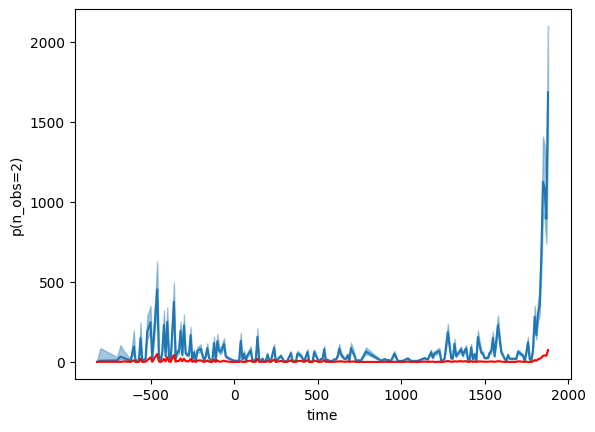

In [24]:
import matplotlib.pyplot as plt


df_filtered = data[data['region_name'] == 'Greek World']

df_filtered = df_filtered.groupby('decade').agg({'f0':'sum', 'f1':'sum', 'f2':'sum', 'min_f0':'sum', 'max_f0':'sum'}).reset_index()
df_filtered['N'] = df_filtered['f1'] + df_filtered['f2'] 
df_filtered['N_unseen'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['f0']
df_filtered['N_unseen_min'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['min_f0']
df_filtered['N_unseen_max'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['max_f0']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(df_filtered["decade"], df_filtered['N_unseen'], color='C0')
ax.plot(df_filtered["decade"], df_filtered['N'], color='red')


# Plot credibility bands
ax.fill_between(df_filtered["decade"], df_filtered['N_unseen_min'],  df_filtered['N_unseen_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")

### Plot P(Y=2) for every region

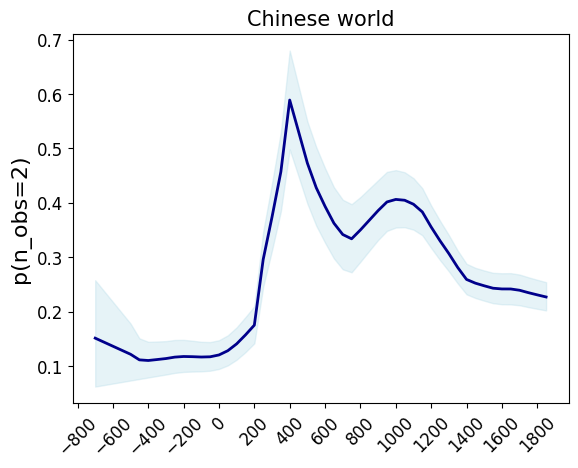

In [25]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Load the data
# data = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv')

# Preparing the data
data_f2 = data[['region_name', 'decade', 'y_mean', 'y_min', 'y_max', 'occupation']].copy()
data_f2['decade'] = (data_f2['decade'] // 50 * 50).astype(int)
data_f2 = data_f2.groupby(['region_name', 'decade', 'occupation'])[['y_mean', 'y_min', 'y_max']].mean().reset_index()
data_f2 = data_f2.groupby(['region_name', 'decade'])[['y_mean', 'y_min', 'y_max']].sum().reset_index()

# Filtering data for 'Chinese world'
data_f2_filtered = data_f2[data_f2['region_name'] == 'Chinese world']

# Fit LOESS models for mean, min, and max

frac = 0.2
loess_mean = sm.nonparametric.lowess(data_f2_filtered['y_mean'], data_f2_filtered['decade'], frac=frac)
loess_min = sm.nonparametric.lowess(data_f2_filtered['y_min'], data_f2_filtered['decade'], frac=frac)
loess_max = sm.nonparametric.lowess(data_f2_filtered['y_max'], data_f2_filtered['decade'], frac=frac)

# Create the plot
fig, ax = plt.subplots()

# Plot the LOESS smoothed mean curve in blue
ax.plot(loess_mean[:, 0], loess_mean[:, 1], color='darkblue', label='LOESS Smoothed Mean', linewidth=2)

# Plot LOESS smoothed confidence bands in a lighter shade of the same blue
ax.fill_between(loess_mean[:, 0], loess_min[:, 1], loess_max[:, 1], alpha=0.3, color='#ADD8E6', label='LOESS Smoothed Confidence Interval')

# Set labels and title
ax.set_xlabel("")
ax.set_ylabel("p(n_obs=2)", fontsize = 16)
ax.set_title("'")



# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=12)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=12)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1850 + 1, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_title('Chinese world', fontsize = 15)


plt.show()
